# Introduction to Tensorflow

> Written by Dr Daniel Buscombe, Northern Arizona University

> Part of a series of notebooks for image recognition and classification using deep convolutional neural networks

The notebook is an introduction to the tensorflow library, which is a popular tool for implementing machine (especially deep) learning

![](figs/tf_logo.jpg)

## Concepts

TensorFlow is a way of representing computation without actually performing it until asked. In this sense, it is a form of lazy computing, and it allows for some great improvements to the running of code:

* Faster computation of complex variables
* Distributed computation across multiple systems, including GPUs.
* Reduced redundency in some computations

TensorFlow allows you to create dataflow graphs

These are structures that describe how data moves through a graph, or a series of processing nodes. 

Each node in the graph represents a mathematical operation, and each connection or edge between nodes is a multidimensional data array, or tensor.

Let’s have a look at this in action. First, a very basic python script:

In [1]:
x = 35
y = x + 5
print(y)

40


a TensorFlow equivalent:

In [2]:
import  tensorflow  as tf

x = tf.constant(35, name='x')
y = tf.Variable(x + 5, name='y')

print(y)

<tf.Variable 'y:0' shape=() dtype=int32_ref>


The output isn't 40. Why? 

our program actually does something quite different to the previous one. The code here does the following:

* Import the tensorflow module and call it tf
* Create a constant value called x, and give it the numerical value 35
* Create a Variable called y, and define it as being the equation x + 5
* Print out the equation object for y

 In effect, y is “when this variable is computed, take the value of x (as it is then) and add 5 to it”. 
    
The computation of the value of y is never actually performed. Let's change that:

In [3]:
model = tf.global_variables_initializer()

with tf.Session() as session:
    session.run(model)
    print(session.run(y))

40


What did this do?
* Initialize the variables with global_variables_initializer
* Create a session for computing the values
* Run the model 
* Run just the variable y and print out its current value

when we initialize the variables, a graph is created of the dependencies between the variables. In this case, the variable y depends on the variable x, and that value is transformed by adding 5 to it. Keep in mind that this value isn’t computed until the last step, as up until then, only equations and relations are computed.

## Working with imagery

In [4]:
from imageio import imread
import matplotlib.pyplot as plt
import s3fs
fs = s3fs.S3FileSystem(anon=True)
root = 'esipfed/cdi-workshop'

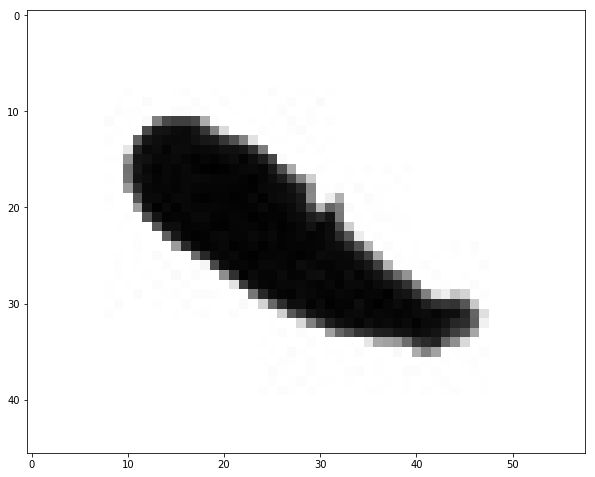

In [5]:
with fs.open(root+'/imrecog_data/plankton/train/amphipods/10494.jpg', 'rb') as f:
    image = imread(f, 'jpg') 
plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray');    

### Geometric transformations

The first transformation we will perform is a transpose, turning the image 90 degrees counter-clockwise

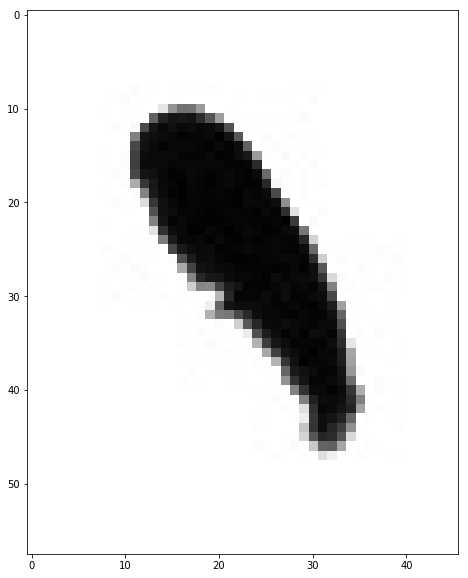

In [6]:
# Create a Tensorflow Variable
x = tf.Variable(image, name='x')

model = tf.global_variables_initializer() 

with tf.Session() as session:
    x = tf.transpose(x)
    session.run(model)
    result = session.run(x)
        
plt.figure(figsize=(10,10))        
plt.imshow(result, cmap='gray')

## Placeholders and 'feed dictionaries'

So far we have used variables to manage our data, but there is a more basic structure, the placeholder. 

A placeholder is simply a variable that we will assign data to at a later date. It allows us to create our operations and build our computation graph, without needing the data. 

In Tensorflow terminology, we then feed data into the graph through these placeholders.

We create a placeholder called x, i.e. a place in memory where we will store value later on. The 'None' on this line allows x to be any length

In [7]:
x = tf.placeholder("float", None)

Then, we create a Tensor called, which is the operation of multiplying x by 2. Note that we haven’t defined any initial values for x yet.

In [8]:
y = x * 2

In [9]:
y

<tf.Tensor 'mul:0' shape=<unknown> dtype=float32>

We now have an operation (y) defined, and can now run it in a session. 

We create a session object, and then run just the y variable. This means that if we defined a much larger graph of operations, we can run just a small segment of the graph. This subgraph evaluation is actually a bit selling point of TensorFlow, and one that isn’t present in many other libraries that do similar things.

Running y requires knowledge about the values of x. We define these inside the feed_dict argument to run. We state here that the values of x are [1, 2, 3]. We run y, giving us the result of [2, 4, 6].

In [10]:
with tf.Session() as session:
    result = session.run(y, feed_dict={x: [1, 2, 3]})
    print(result)

[2. 4. 6.]


when we define the values of x in the feed_dict we can have any number of values. The code should still work, and give the same answer, but now it will also work with any number of values in feed_dict.

In [11]:
with tf.Session() as session:
    x_data = [[1, 2, 3],
              [4, 5, 6],]
    result = session.run(y, feed_dict={x: x_data})
    print(result)

[[ 2.  4.  6.]
 [ 8. 10. 12.]]


We can extend this to take an arbitrary number of None dimensions. In this example, we load up the image from our last lesson, then create a placeholder that stores a slice of that image. 

We then use TensorFlow’s slice method to take a subsegment out of the image to operate on.

We'll take a 20 pixel slice (in vertical) starting at x=10, y=10

(20, 48)


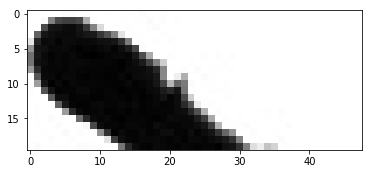

In [12]:
image_placeholder = tf.placeholder("uint8", [None, None])
slice = tf.slice(image_placeholder, [10, 10], [20, -1])

with tf.Session() as session:
    result = session.run(slice, feed_dict={image_placeholder: image})
    print(result.shape)

plt.imshow(result, cmap='gray')

For a RGB image:

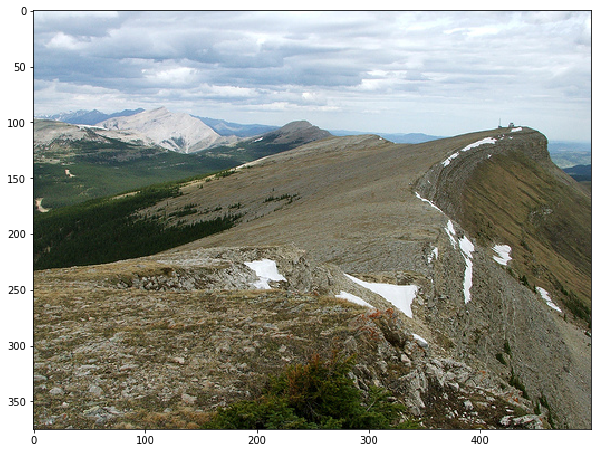

In [13]:
with fs.open(root+'/imrecog_data/Imagenet/train/butte/n09230202_10020.JPEG', 'rb') as f:
    image = imread(f, 'jpg') 
plt.figure(figsize=(10,10))
plt.imshow(image);  

(200, 490, 3)


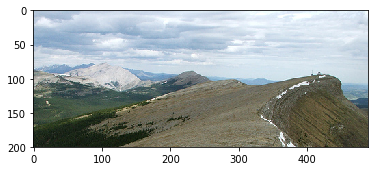

In [14]:
image_placeholder = tf.placeholder("uint8", [None, None, None])
slice = tf.slice(image_placeholder, [10, 10, 0], [200, -1, -1])

with tf.Session() as session:
    result = session.run(slice, feed_dict={image_placeholder: image})
    print(result.shape)

plt.imshow(result)

In the above -1 means "all". We can replace that with an actual length in the horizontal dimension

(200, 100, 3)


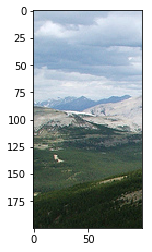

In [31]:
image_placeholder = tf.placeholder("uint8", [None, None, None])
slice = tf.slice(image_placeholder, [10, 10, 0], [200, 100, -1])

with tf.Session() as session:
    result = session.run(slice, feed_dict={image_placeholder: image})
    print(result.shape)

plt.imshow(result)

## Lots of other operations in ```tf.image``` class

For example, adjusting image brightness

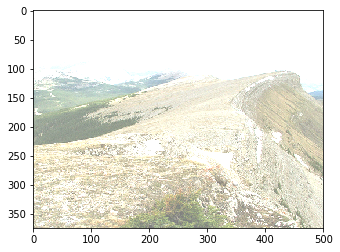

In [23]:
with tf.Session() as session:
    result = session.run(tf.image.adjust_brightness(image, 0.5))

plt.imshow(result)

Flipping

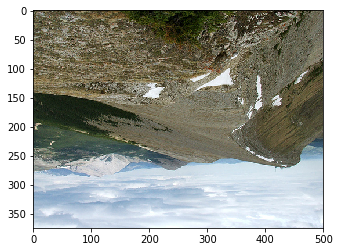

In [24]:
with tf.Session() as session:
    result = session.run(tf.image.flip_up_down(image))

plt.imshow(result)

Colorspace transformations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


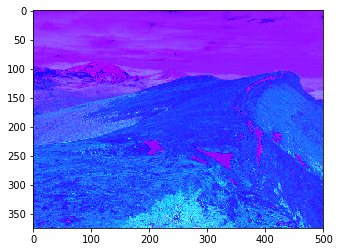

In [25]:
with tf.Session() as session:
    result = session.run(tf.image.rgb_to_hsv(image))

plt.imshow(result)

etc, etc

In [28]:
tf.image??

Type:        module
String form: <module 'tensorflow.image' from '/opt/conda/lib/python3.6/site-packages/tensorflow/image/__init__.py'>
File:        /opt/conda/lib/python3.6/site-packages/tensorflow/image/__init__.py
Source:     
# This file is MACHINE GENERATED! Do not edit.
# Generated by: tensorflow/python/tools/api/generator/create_python_api.py script.
"""Image processing and decoding ops.

See the @{$python/image} guide.

"""

from __future__ import print_function

from tensorflow.python import extract_image_patches
from tensorflow.python.ops.gen_image_ops import crop_and_resize
from tensorflow.python.ops.gen_image_ops import decode_and_crop_jpeg
from tensorflow.python.ops.gen_image_ops import decode_bmp
from tensorflow.python.ops.gen_image_ops import decode_gif
from tensorflow.python.ops.gen_image_ops import decode_jpeg
from tensorflow.python.ops.gen_image_ops import decode_png
from tensorflow.python.ops.gen_image_ops import draw_bounding_boxes
from tensorflow.python.ops.gen_ima